In [6]:
import pandas as pd, numpy as np
import glob
import os
import csv
# 一次性merge多个pct_chg
from functools import reduce
from datetime import datetime, timedelta

# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

In [209]:
from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

1. Download ETFs' most recent data
2. Use market cap to filter out the largest ETFs by market cap
3. Use correlation to filter out the most uncorrelated ETFs
4. Generate selected 40 tickers as pool
5. Calculate the positions' weights

# General Import of ETF Data

In [169]:
def handle_data_files_return_tickers(file_path):
    ch_etfs_df = pd.read_csv(file_path, engine="python")
    ch_etfs_df.dropna(inplace = True)
    ch_etfs_df['基金规模\n[单位] 元'] = ch_etfs_df['基金规模\n[单位] 元'].apply(lambda x: float(x.replace(",","")))
    ch_etfs_df['机构投资者持有份额\n[报告期] 2019中报\n[单位] 份'] = ch_etfs_df['机构投资者持有份额\n[报告期] 2019中报\n[单位] 份'].apply(lambda x: float(x.replace(",","")))
    ch_etfs_df.sort_values("基金规模\n[单位] 元", ascending=False, inplace =True)
    ch_etfs_df = ch_etfs_df
    ch_etfs = ch_etfs_df.copy()
    ch_etfs['code'] =ch_etfs['证券代码'].apply(lambda x: str(x)[:6])
    ch_etfs_ticker = list(ch_etfs['code'].unique())
    return ch_etfs_ticker

def select_df_from_db_by_tickers(path, ticker_list):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    csv_path = path+"*.csv"
    files = glob.glob(csv_path)
    
    tickers_data = []
    if len(ticker_list)!=1:
        for ticker in ticker_list:
            print("Reading: ", ticker)
            df = pd.read_csv(path+ticker+".csv")
            tickers_data.append(df)
        tickers_data_concated = pd.concat(tickers_data)
        tickers_data_concated.reset_index(inplace=True)
        del tickers_data_concated['index']
    else:
        df = pd.read_csv(path+ticker_list[0]+".csv")
        tickers_data_concated = df
    return tickers_data_concated

def get_df_date_price_code(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df = ticker_df[[date_col, 'close']].dropna()
            ticker_df.columns = [date_col,ticker]
            ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df_list.append(ticker_df)
            tickers_data_concated = pd.concat(ticker_df_list)
#             tickers_data_concated.reset_index(inplace=True)
#             del tickers_data_concated['index']
        except:
            pass
    return tickers_data_concated

In [9]:
# 先为之后使用reduce铺路：创造一个merge的函数，这里的目的是为了将多资产数据基于date_col进行merge：
def merge_df(df1, df2, date_col="date"):
    # By default the etf's date_col goes by 'date'
    merged = df1.merge(df2, on = date_col, how = 'outer')
    merged.sort_values(date_col, inplace = True)
    return merged

In [15]:
etf_ticker_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_ETFs.csv"
etf_path_to_csv = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
ch_etfs_tickers = handle_data_files_return_tickers(etf_ticker_path)
tickers_data_concated = select_df_from_db_by_tickers(etf_path_to_csv, ch_etfs_tickers)

In [18]:
tickers_data_concated.head()

,date,open,close,high,low,volume,code
0,2013-03-15,0.967,0.970,0.985,0.955,3259273.0,510500
1,2013-03-18,0.955,0.954,0.972,0.953,936962.0,510500
2,2013-03-19,0.956,0.960,0.960,0.941,1080499.0,510500
3,2013-03-20,0.960,0.985,0.986,0.958,501195.0,510500
4,2013-03-21,0.985,0.995,0.996,0.981,698243.0,510500


# Use Volume to Rank

Every year we will need to check using this function. The most recent time of update is 20200221

In [148]:
def vol_ewm(vol_series, window_span):
    vol_mean = vol_series.ewm(span = window_span).mean()
    return vol_mean

def add_vol_ewm_col(df, code_col, vol_col, window_span):
    vol_col_rename = str(window_span)+"_vol_ewm"
    df[vol_col_rename] = df.groupby([code_col])[vol_col].apply(lambda x: vol_ewm(x, window_span))
    return df

def rank_by_vol_ewm(df, date_col, window_span, rank_num, ascending_default = False):
    vol_col_rename = "{}_vol_ewm".format(window_span)
    df['vol_ewm_rank'] = df.groupby([date_col])[vol_col_rename].apply(lambda x: x.rank(ascending = ascending_default))
    vol_rank_condition = df['vol_ewm_rank']<=rank_num
    vol_filtered_df = df[(df[date_col]==df[date_col].values[-1])&(vol_rank_condition)]
    vol_filtered_df.sort_values("vol_ewm_rank", ascending=True, inplace=True)
    return vol_filtered_df

def filtered_tickers(df, code_col):
    filtered_tickers = list(df[code_col].unique().astype(str))
    return filtered_tickers

In [149]:
vol_added_df = add_vol_ewm_col(tickers_data_concated,'code','volume',252)
vol_filtered_df = rank_by_vol_ewm(vol_added_df, 'date', 252, 50, ascending_default = False)
vol_filtered_tickers = filtered_tickers(vol_filtered_df, 'code')

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [150]:
len(vol_filtered_tickers)

50

# Calculate Correlations as Filters

In [95]:
def merge_df_for_corr(ticker_df_list, date_col):
    # Here below merge_df is a function instead of a variable
    
    merged_all = reduce(merge_df, ticker_df_list)
    # For etf data the date col is 'date'
    merged_all.set_index(date_col, inplace=True)
    merged_all.dropna(how="all", axis = 1, inplace = True)
    return merged_all

def get_df_date_price_code_returns(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df['cum_returns'] = ticker_df['pct_chg'].cumsum()
            ticker_df = ticker_df[[date_col, 'pct_chg']].dropna()
            ticker_df.columns = [date_col,ticker]
            ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df_list.append(ticker_df)
        except:
            pass
    return ticker_df_list

def get_df_date_price_code_cumreturns(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df['cum_returns'] = ticker_df['pct_chg'].cumsum()
            ticker_df = ticker_df[[date_col, 'cum_returns']].dropna()
            ticker_df.columns = [date_col,ticker]
            ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df_list.append(ticker_df)
        except:
            pass
    return ticker_df_list

In [96]:
df_returns = get_df_date_price_code_returns(etf_path_to_csv, vol_filtered_tickers, 'date', 'close', 'code')
df_cum_returns = get_df_date_price_code_cumreturns(etf_path_to_csv, vol_filtered_tickers, 'date', 'close', 'code')
merged_returns = merge_df_for_corr(df_returns, "date")
merged_cumreturns = merge_df_for_corr(df_cum_returns, "date")

Reading Assets:  510900
Reading Assets:  512880
Reading Assets:  159949
Reading Assets:  510050
Reading Assets:  159915
Reading Assets:  159920
Reading Assets:  512000
Reading Assets:  510300
Reading Assets:  518880
Reading Assets:  510500
Reading Assets:  512660
Reading Assets:  510330
Reading Assets:  159919
Reading Assets:  512800
Reading Assets:  512380
Reading Assets:  512500
Reading Assets:  512960
Reading Assets:  510850
Reading Assets:  512280
Reading Assets:  512290
Reading Assets:  159939
Reading Assets:  512090
Reading Assets:  510310
Reading Assets:  513500
Reading Assets:  159952
Reading Assets:  513050
Reading Assets:  512160
Reading Assets:  512010
Reading Assets:  159901
Reading Assets:  512980
Reading Assets:  512400
Reading Assets:  510510
Reading Assets:  512180
Reading Assets:  512950
Reading Assets:  512690
Reading Assets:  513100
Reading Assets:  512900
Reading Assets:  512100
Reading Assets:  510180
Reading Assets:  510360
Reading Assets:  159905
Reading Assets: 

Text(0.5, 1.0, 'Cumulative Returns on 50 ETFs')

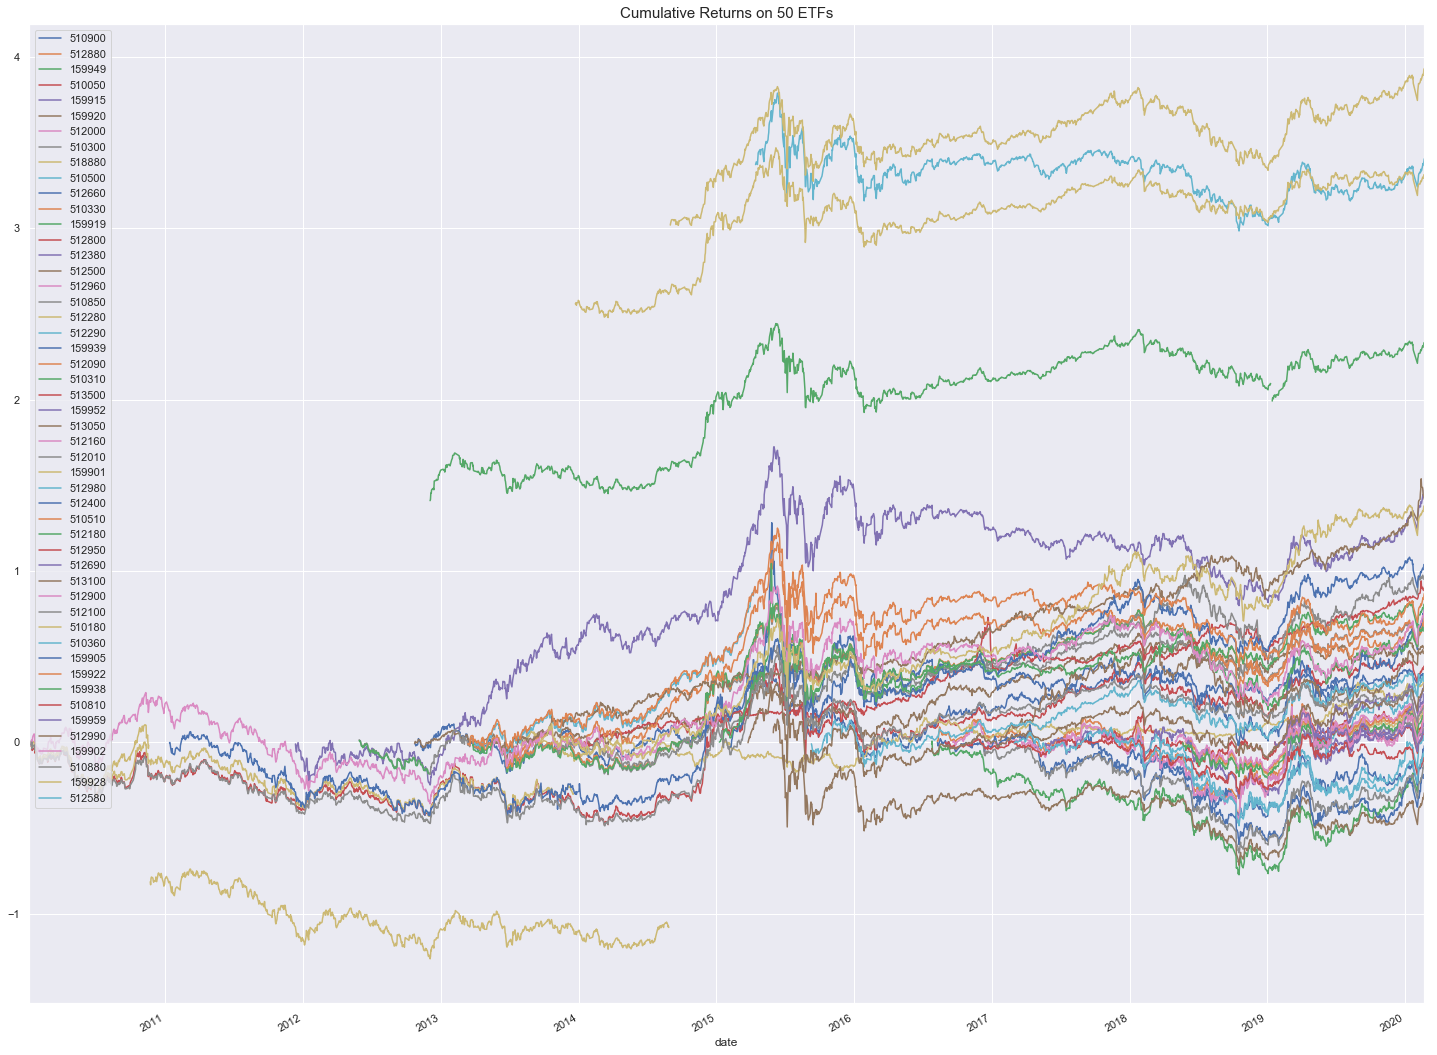

In [101]:
merged_cumreturns.plot(figsize = (25, 20))
plt.title("Cumulative Returns on 50 ETFs", fontsize = 15)

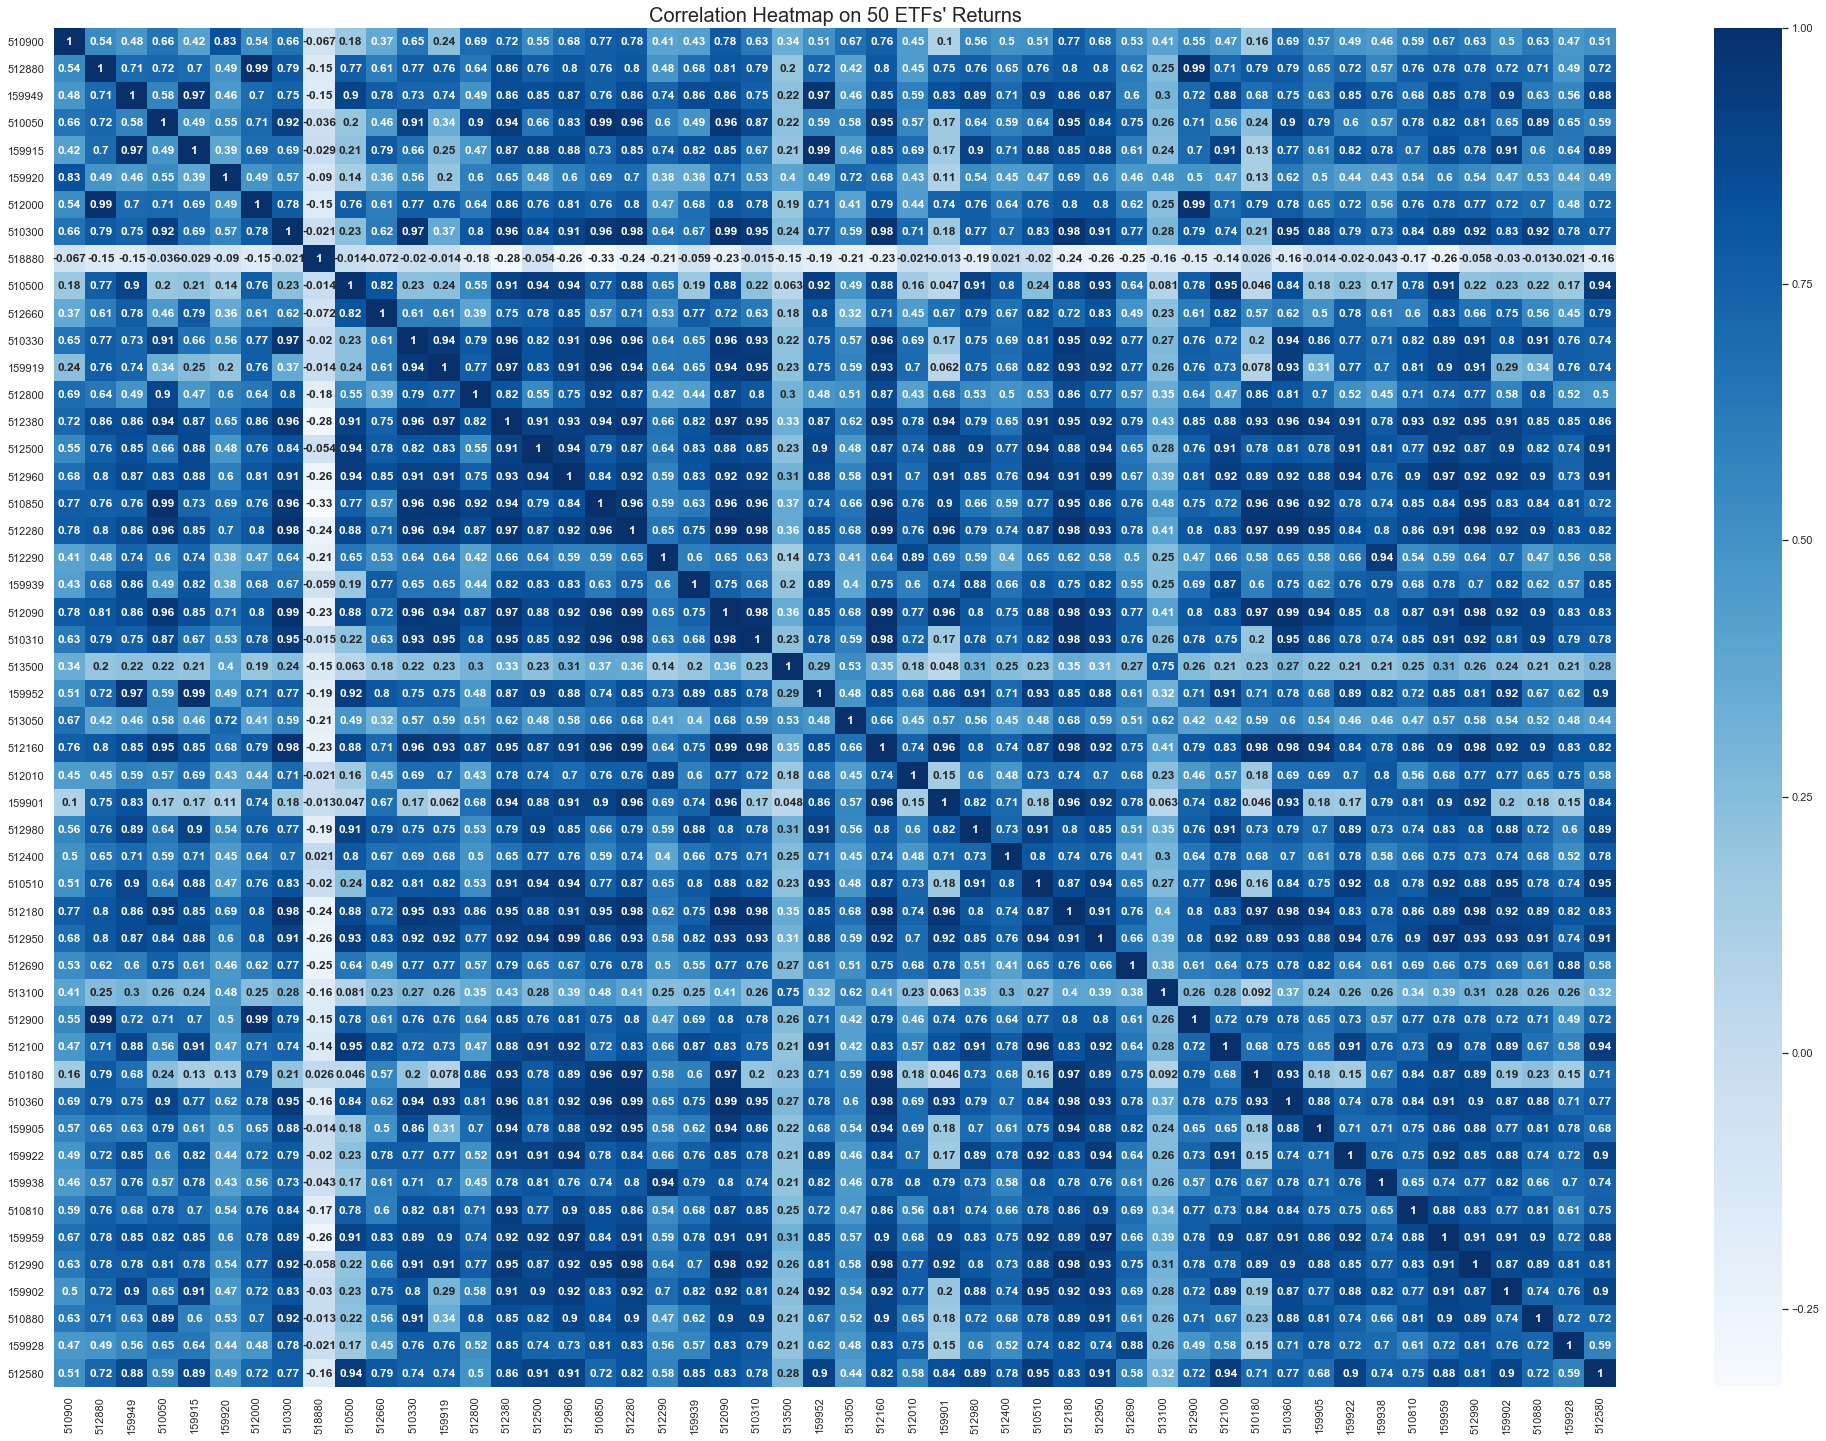

In [100]:
fig = plt.figure(figsize = (35, 25))
ax = fig.add_subplot(111)
ax = sns.heatmap(merged_returns.corr(),\
                annot=True, annot_kws={'size':12, 'weight': 'bold'}, cmap = 'Blues')
plt.title("Correlation Heatmap on 50 ETFs' Returns", fontsize = 20);

# Check Details of Filtered ETFs

In [ ]:
og_etf_file = pd.read_csv(etf_ticker_path)
corr_mean_df_assets['etf'] = corr_mean_df_assets['etf']+".OF"
og_etf_file.columns = ['etf', '证券简称', '投资类型(一级分类)', '投资类型(二级分类)', '基金规模\n[单位] 元',
       '机构投资者持有份额\n[报告期] 2019中报\n[单位] 份', '机构投资者持有比例\n[报告期] 2019中报\n[单位] %',
       '管理费率\n[单位] %', '托管费率\n[单位] %', '认购费率\n[收费类型] 前端']
corr_mean_df_assets_info = corr_mean_df_assets.merge(og_etf_file, on = 'etf')

In [131]:
corr_mean_df_assets_info

,etf,abs_corr_mean,证券简称,投资类型(一级分类),投资类型(二级分类),基金规模\n[单位] 元,机构投资者持有份额\n[报告期] 2019中报\n[单位] 份,机构投资者持有比例\n[报告期] 2019中报\n[单位] %,管理费率\n[单位] %,托管费率\n[单位] %,认购费率\n[收费类型] 前端
0,518880.OF,0.137446,华安黄金ETF,另类投资基金,商品型基金,"8,597,897,261.42","1,167,058,402.00",65.07,0.50,0.10,"500元/笔,通过基金管理人现金认购本基金份额的养老金客户认购费率。\n100万份以上 10..."
1,513500.OF,0.278739,博时标普500ETF,国际(QDII)基金,国际(QDII)股票型基金,"1,140,905,623.78","381,967,798.00",79.11,0.60,0.25,100万份以上 1000元/笔\n50万份以下 0.8%\n50~100万份 0.5%\n
2,513100.OF,0.327177,国泰纳斯达克100ETF,国际(QDII)基金,国际(QDII)股票型基金,"647,692,048.14","72,534,557.00",33.95,0.60,0.20,100万份以上 1000元/笔\n50万份以下 0.8%\n50~100万份 0.5%\n
3,159920.OF,0.501273,华夏恒生ETF,国际(QDII)基金,国际(QDII)股票型基金,"5,946,218,221.69","2,499,516,196.00",91.04,0.60,0.15,50万份以上 1000元/笔\n50万份以下 0.8%\n
4,510500.OF,0.526850,南方中证500ETF,股票型基金,被动指数型基金,"43,495,546,173.14","6,869,516,878.00",76.03,0.50,0.10,500万份以上 1000元/笔\n100万份以下 1%\n100~300万份 0.6%\n3...
5,513050.OF,0.535308,易方达中证海外互联ETF,国际(QDII)基金,国际(QDII)股票型基金,"1,186,280,440.54","208,332,418.00",30.94,0.60,0.25,100万份以上 1000元/笔\n50万份以下 0.8%\n50~100万份 0.5%\n
6,510180.OF,0.541800,华安上证180ETF,股票型基金,被动指数型基金,"19,583,754,450.70","5,378,176,558.00",95.37,0.50,0.10,100万份以下 1%\n100~1000万份 0.8%\n1000万份以上 0.5%\n
7,510900.OF,0.545063,易方达恒生H股ETF,国际(QDII)基金,国际(QDII)股票型基金,"8,830,763,408.07","4,901,017,066.00",81.04,0.60,0.20,100万份以上 1000元/笔\n50万份以下 0.8%\n50~100万份 0.5%\n
8,159901.OF,0.550628,易方达深证100ETF,股票型基金,被动指数型基金,"7,455,376,003.75","1,164,431,275.00",77.25,0.50,0.10,100万份以上 1000元/笔\n50万份以下 1%\n50~100万份 0.5%\n
9,512290.OF,0.585139,国泰中证生物医药ETF,股票型基金,被动指数型基金,"384,853,456.61","274,128,060.00",45.93,0.50,0.10,100万份以上 1000元/笔\n50万份以下 1%\n50~100万份 0.5%\n


# Filter the top 40 ETFs by Lowest Correlations

In [109]:
def select_N_lowest_corr_assets(merged_all, asset_category, n):
    # asset_category be default for etf is 'etf'
    # Create ETFs' correlation matrix dataframe
    merged_all_corr = merged_all.corr()
    merged_all_corr_abs = abs(merged_all_corr)
    corr_mean_dict = {}
    for row in merged_all_corr_abs.iterrows():
        row_list = list(row)
        print(row_list[0])
        print(np.mean(row_list[1]))
        corr_mean_dict[row_list[0]] = np.mean(row_list[1])
        print("========")
    corr_mean_df = pd.DataFrame()
    corr_mean_df[asset_category] = corr_mean_dict.keys()
    corr_mean_df['abs_corr_mean'] = corr_mean_dict.values()
    corr_mean_df_assets = corr_mean_df.sort_values("abs_corr_mean", ascending=True)
    lowest_corr_assets_list = list(corr_mean_df_assets[asset_category])[:n]
    return lowest_corr_assets_list, corr_mean_df_assets

def MACD(df, n_fast, n_slow, n_macd, price_col): # n_fast = 12, n_slow = 26
    """
    http://stockcharts.com/docs/doku.php?id=scans:indicators
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df['MACD_Diff'] = MACD
    df['MACD_Diff_EMA'] = MACDsign
    df['MACD'] = MACDdiff
    df['SIGNAL_STATUS'] = df['MACD'].apply(lambda x: "多头状态" if x>0 else ("空头状态" if x<0 else "无信号状态"))
    return df

def calc_macd_signals(tickers_data_concated, ticker_list, code_col, ticker_type, price_col):
    signal_record = []
    signal_data = []
    if len(ticker_list)!=1:
        for ticker in ticker_list:
            print("Calculating Signal for: ", ticker)
            try:
                if ticker_type == "float":
                # Be aware of types of ticker values here, whether it's float or strings, depends.
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==float(ticker)]
                elif ticker_type == "string":
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==ticker]
                signal_df = MACD(single_ticker_df, 12, 26, 9, price_col)
#                 last_signal = signal_df[[code_col,'SIGNAL_STATUS']].values[-1]
                signal_data.append(signal_df)
#                 signal_record.append(last_signal)
            except:
                pass
        signal_data_df = pd.concat(signal_data)
    else:
        print("Calculating Signal for: ", ticker_list[0])
        try:                
            print("getting thru")
            signal_df = MACD(tickers_data_concated, 12, 26, 9, price_col)
#             last_signal = signal_df[[code_col,'SIGNAL_STATUS']].values[-1]
#             signal_data.append(signal_df)
#             signal_record.append(last_signal)
        except:
            pass
        signal_data_df = signal_df
    return signal_data_df
    
def make_numeric_signals(series):
    for item in series:
#         print(item)
        if item =="多":
            return 1
        elif item =="空":
            return -1
        else:
            return 0
        
def generate_most_recent_signal_data_v1(signal_data_df, date_col, code_col):
    # v1 is the version of generating the og macd signals
    signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: make_numeric_signals(x))
    signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([code_col])['SIGNAL_DIRECTION'].diff()
    signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
    most_recent_signals = signal_data_df.groupby([code_col])[[date_col,code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
    return most_recent_signals

def check_macd_signal_plot(signal_data_df, ticker, cols_list_to_plot, code_col, N_tails, date_col):
    signal_data_df_copy = signal_data_df.copy()
    signal_data_df_copy.set_index(date_col, inplace = True)
    df_to_plot = signal_data_df_copy[signal_data_df_copy[code_col]==ticker][cols_list_to_plot].tail(N_tails)
    df_to_plot.plot(figsize = (18, 6))
    plt.title("{}".format(ticker))

In [104]:
lowest_corr_etf_list,corr_mean_df_assets = select_N_lowest_corr_assets(merged_returns, "etf", 40)

# Calculate MACD
# P.S. MACD is calculated based on the following df structure: date, open, high, low, close
lowest_corr_etf_df = select_df_from_db_by_tickers(etf_path_to_csv, lowest_corr_etf_list)
lowest_corr_etf_macd_signals = calc_macd_signals(lowest_corr_etf_df, lowest_corr_etf_list, 'code', 'float','close')
most_recent_etf_macd_signals = generate_most_recent_signal_data_v1(lowest_corr_etf_macd_signals, 'date','code')

510900
0.545063301187227
512880
0.6902132942781367
159949
0.7292785259327139
510050
0.6614497895199232
159915
0.6713744882016851
159920
0.5012733842117469
512000
0.6867642675267779
510300
0.7358035800058075
518880
0.1374455184723802
510500
0.5268498480121017
512660
0.624440867654658
510330
0.7351852707658992
159919
0.648774248847601
512800
0.6353935473992814
512380
0.8402757125947039
512500
0.7716797067674673
512960
0.8212405718679757
510850
0.7941010615215456
512280
0.8378541428865414
512290
0.5851394046281663
159939
0.6608750078673505
512090
0.8396062383587766
510310
0.7444016286554755
513500
0.27873914047542003
159952
0.749368418069156
513050
0.5353081757213343
512160
0.8337255952454927
512010
0.593648941287134
159901
0.5506278103936372
512980
0.7390250014342905
512400
0.641344213625803
510510
0.732235739850751
512180
0.8332020883378851
512950
0.8235248199790552
512690
0.6473253205631331
513100
0.3271766336007241
512900
0.6919668787818005
512100
0.7333758766754573
510180
0.541799526

In [155]:
lowest_corr_etf_df.head(2)

,date,open,close,high,low,volume,code
0,2013-07-29,2.633,2.626,2.640,2.614,1404335.0,518880
1,2013-07-30,2.632,2.646,2.648,2.632,929931.0,518880


In [185]:
# This could be different from our current position holdings
most_recent_etf_macd_signals['TYPE'] = 'TARGET'

In [186]:
most_recent_etf_macd_signals

,date,code,SIGNAL_STATUS,SIGNAL_ACTION,TYPE
1599,2020-02-21,518880,多头状态,NO CHANGE,TARGET
3085,2020-02-21,513500,空头状态,SHORT,TARGET
4735,2020-02-21,513100,空头状态,NO CHANGE,TARGET
6519,2020-02-21,159920,多头状态,NO CHANGE,TARGET
8205,2020-02-21,510500,多头状态,NO CHANGE,TARGET
8956,2020-02-21,513050,空头状态,NO CHANGE,TARGET
11416,2020-02-21,510180,多头状态,NO CHANGE,TARGET
13199,2020-02-21,510900,多头状态,NO CHANGE,TARGET
15659,2020-02-21,159901,多头状态,NO CHANGE,TARGET
15845,2020-02-21,512290,空头状态,NO CHANGE,TARGET


In [151]:
# Mannually check our current position holdings for potential exit signals:
cur_positions = [
    '159916',
    '159918',
    '159920',
    '159932',
    '159933',
    '159951',
    '159960',
    '510090',
    '510110',
    '510270',
    '510580',
    '511030',
    '512560',
    '513030',
    '513600',
    '513660'
]
len(cur_positions)

16

In [183]:
cur_pos_prices = select_df_from_db_by_tickers(etf_path_to_csv, cur_positions)
cur_pos_etf_macd_signals = calc_macd_signals(cur_pos_prices, cur_positions, 'code', 'float','close')
most_recent_cur_pos_etf_macd_signals = generate_most_recent_signal_data_v1(cur_pos_etf_macd_signals, 'date','code')
most_recent_cur_pos_etf_macd_signals['TYPE'] = 'CUR_POS'

Reading:  159916
Reading:  159918
Reading:  159920
Reading:  159932
Reading:  159933
Reading:  159951
Reading:  159960
Reading:  510090
Reading:  510110
Reading:  510270
Reading:  510580
Reading:  511030
Reading:  512560
Reading:  513030
Reading:  513600
Reading:  513660
Calculating Signal for:  159916
Calculating Signal for:  159918
Calculating Signal for:  159920
Calculating Signal for:  159932
Calculating Signal for:  159933
Calculating Signal for:  159951
Calculating Signal for:  159960
Calculating Signal for:  510090


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

Calculating Signal for:  510110
Calculating Signal for:  510270
Calculating Signal for:  510580
Calculating Signal for:  511030
Calculating Signal for:  512560
Calculating Signal for:  513030
Calculating Signal for:  513600
Calculating Signal for:  513660


In [194]:
most_recent_cur_pos_etf_macd_signals.merge(most_recent_etf_macd_signals, on=['date','code'], how='outer')

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y
0,2020-02-21,159916,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
1,2020-02-21,159918,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
2,2020-02-21,159920,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET
3,2020-02-21,159932,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
4,2020-02-21,159933,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
5,2020-02-21,159951,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
6,2020-02-21,159960,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
7,2020-02-21,510090,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
8,2020-02-21,510110,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN
9,2020-02-21,510270,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN


# Risk Parity

In [135]:
from scipy.optimize import minimize

def get_smart_weight(pct, method='risk parity', cov_adjusted=False, wts_adjusted=False):
    if cov_adjusted == False:
        #协方差矩阵
        cov_mat = pct.cov()
    else:
        #调整后的半衰协方差矩阵
        cov_mat = pct.iloc[:len(pct)/4].cov()*(1/10.) + pct.iloc[len(pct)/4+1:len(pct)/2].cov()*(2/10.) +\
            pct.iloc[len(pct)/2+1:len(pct)/4*3].cov()*(3/10.) + pct.iloc[len(pct)/4*3+1:].cov()*(4/10.)
    if not isinstance(cov_mat, pd.DataFrame):
        raise ValueError('cov_mat should be pandas DataFrame！')
        
    omega = np.matrix(cov_mat.values)  # 协方差矩阵

    a, b = np.linalg.eig(np.array(cov_mat)) #a为特征值,b为特征向量
    a = np.matrix(a)
    b = np.matrix(b)
    # 定义目标函数
    
    def fun1(x):
        tmp = (omega * np.matrix(x).T).A1
        risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    def fun2(x):
        tmp = (b**(-1) * omega * np.matrix(x).T).A1
        risk = (b**(-1)*np.matrix(x).T).A1 * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    # 初始值 + 约束条件 
    x0 = np.ones(omega.shape[0]) / omega.shape[0]  
    bnds = tuple((0,None) for x in x0)
    cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})
    options={'disp':False, 'maxiter':1000, 'ftol':1e-20}
        
    if method == 'risk parity':
        res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    elif method == 'pc risk parity':
        res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    else:
        raise ValueError('method error！！！')
        
    # 权重调整
    if res['success'] == False:
        # print res['message']
        pass
    wts = pd.Series(index=cov_mat.index, data=res['x'])
    
    if wts_adjusted == True:
        wts[wts < 0.0001]=0.0
        wts = wts / wts.sum()
    elif wts_adjusted == False:
        wts = wts / wts.sum()
    else:
        raise ValueError('wts_adjusted should be True/False！')
        
    risk = pd.Series(wts * (omega * np.matrix(wts).T).A1 / np.sqrt(np.matrix(wts) * omega * np.matrix(wts).T).A1[0],index = cov_mat.index)
    risk[risk<0.0] = 0.0
    return wts,risk

In [136]:
wts, risk = get_smart_weight(merged_returns, method='risk parity', cov_adjusted=False, wts_adjusted=False)

In [137]:
df_wts = pd.DataFrame(wts)
df_wts.reset_index(inplace = True)
df_wts.columns = ['ETF', 'Portfolio_Weight']

In [144]:
# Top 40 ETF ranked by 252-day-vol_ewm on 20200221
# list(merged_returns.columns)

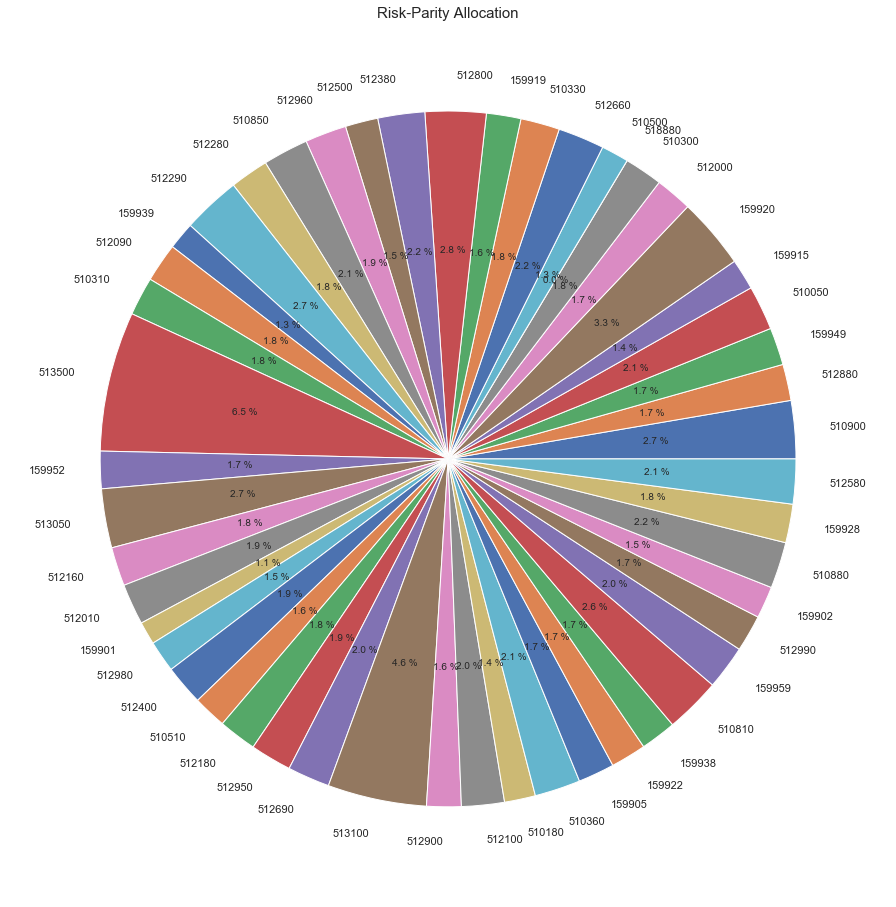

In [139]:
etfs = list(df_wts['ETF'])
weights = list(df_wts['Portfolio_Weight'])
# 保证圆形
plt.figure(1, figsize = (16, 16))
plt.axes(aspect=1)
plt.pie(x=weights, labels=etfs, autopct='%3.1f %%')
plt.title("Risk-Parity Allocation", fontsize = 15)
plt.show()

In [196]:
# check
df_wts

,ETF,Portfolio_Weight
0,510900,2.693868e-02
1,512880,1.684896e-02
2,159949,1.738924e-02
3,510050,2.065919e-02
4,159915,1.431565e-02
5,159920,3.293588e-02
6,512000,1.713708e-02
7,510300,1.776577e-02
8,518880,9.390973e-19
9,510500,1.274023e-02


# Performance Tracking

In [197]:
date = [
    "2020-01-02",
    "2020-01-03",
    "2020-01-06",
    "2020-01-07",
    "2020-01-08",
    "2020-01-09",
    "2020-01-10",
    "2020-01-13",
    "2020-01-14",
    "2020-01-15",
    "2020-01-16",
    "2020-01-17",
    "2020-01-20",
    "2020-01-21",
    "2020-01-22",
    "2020-01-23",
    "2020-02-03",
    "2020-02-04",
    "2020-02-05",
    "2020-02-06",
    "2020-02-07",
    "2020-02-10",
    "2020-02-11",
    "2020-02-12",
    "2020-02-13",
    "2020-02-14",
    "2020-02-17",
    "2020-02-18",
    "2020-02-19",
    "2020-02-20",
    "2020-02-21"
]
sbtv1 = [0+1,#1/2
        0+1,
        0+1,
        0+1,
        -0.005/100+1,
        -0.001/100+1,
        0.01/100+1,
        0.01/100+1,
        0.03/100+1,
        0.02/100+1,
        -0.03/100+1,
        0.06/100+1,
        0.07/100+1,
        0.13/100+1,
        0.0795/100+1,
        0.2/100+1,
        0.68136/100+1,
         710/200000+1,#2/4
         824.42/200000+1,#2/5
         654.42/200000+1,#2/6
         745.42/200000+1,#2/7
         833/200000+1,#2/8
         933/200000+1,#2/11
         911/200000+1,
         676.53/200000+1,
         882.52/200000+1,
         1813.76/200000+1,
         2210.96/200000+1,
         1947.66/200000+1,
         2553.70/200000+1,
         2881.31/200000+1 #2020-02-21
        ]

In [199]:
sh_index = pd.read_csv(etf_path_to_csv+"sh000001.csv")

In [200]:
sh_index.tail()

,trade_date,open,high,low,close,volume,ts_code
7125,2020-02-17,2924.9913,2983.6371,2924.9913,2983.6224,313198007.0,sh000001
7126,2020-02-18,2981.4097,2990.6003,2960.7751,2984.9716,311665913.0,sh000001
7127,2020-02-19,2979.5223,2998.2718,2971.8219,2975.4019,315141151.0,sh000001
7128,2020-02-20,2981.8802,3031.3706,2968.4451,3030.1542,345732881.0,sh000001
7129,2020-02-21,3022.2455,3058.8980,3020.1410,3039.6692,364557276.0,sh000001


In [201]:
sh_index['pct_chg'] = sh_index['close'].pct_change()
sh_index_2020 = sh_index[sh_index['trade_date']>='2020-01-02']
sh_index_2020['adjusted_pct_chg'] = sh_index_2020['pct_chg']
sh_index_2020['adjusted_pct_chg'].values[0] = 0
sh_index_2020['cum_sum_pct_chg'] = sh_index_2020['adjusted_pct_chg'].cumsum()+1

track_record = pd.DataFrame()
track_record['date'] = date
track_record['sbtv1'] = sbtv1
track_record['sh_mkt'] = sh_index_2020['cum_sum_pct_chg'].values
track_record.index = pd.to_datetime(track_record['date'])
del track_record['date']

track_record['returns0'] = track_record['sbtv1'].diff()
track_record['returns0'].values[0] = 0
track_record['returns1'] = track_record['sh_mkt'].diff()
track_record['returns1'].values[0] = 0

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [203]:
def create_sharpe_ratio(returns, periods=252):
    print("*****performance.py: 1. create_sharpe_ratio*****")
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).
    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)

def create_drawdowns(pnl):
    print("*****performance.py: 2. create_drawdowns*****")
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.
    Parameters:
    pnl - A pandas Series representing period percentage returns.
    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()

def create_expected_annual_returns(pnl, periods=252):
    traded_days = len(pnl)
    last_pnl = pnl.values[-1]
    annual_returns = (1+last_pnl)**(periods/traded_days)-1
    return annual_returns

def create_total_returns(pnl):
    return pnl.values[-1]

In [204]:
# Calculate Alpha and Beta:

import statsmodels.api as sm
from statsmodels import regression

X = track_record['returns1'].values
Y = track_record['returns0'].values

def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    
    x = x[:,1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print("alpha: ", str(alpha))
print("beta: ", str(beta))

alpha:  0.00045506488364418005
beta:  -0.029465530906756788


- 计算alpha，beta

https://blog.csdn.net/CoderPai/article/details/82868280 

In [205]:
sharpe_ratio0 = create_sharpe_ratio(track_record['returns0'], periods=252)
sharpe_ratio1 = create_sharpe_ratio(track_record['returns1'], periods=252)
drawdown0, max_drawdown0, max_dd_duration0 = create_drawdowns(track_record['sbtv1'])
drawdown1, max_drawdown1, max_dd_duration1 = create_drawdowns(track_record['sh_mkt'])
annual_returns0 = create_expected_annual_returns(track_record['sbtv1']-1)
annual_returns1 = create_expected_annual_returns(track_record['sh_mkt']-1)
total_returns0 = create_total_returns(track_record['sbtv1']-1)
total_returns1 = create_total_returns(track_record['sh_mkt']-1)
corr_returns0_1 = track_record['returns0'].corr(track_record['returns1'])
# jensen_alpha = total_returns0 - corr_returns0_1*total_returns1

*****performance.py: 1. create_sharpe_ratio*****
*****performance.py: 1. create_sharpe_ratio*****
*****performance.py: 2. create_drawdowns*****
*****performance.py: 2. create_drawdowns*****


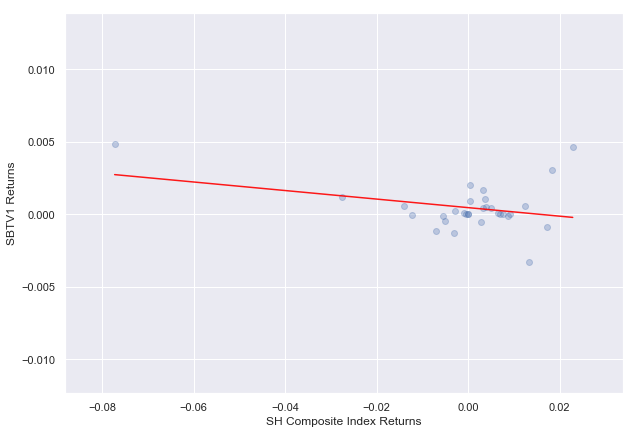

In [206]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2*beta+alpha

plt.figure(figsize=(10,7))
plt.scatter(X ,Y, alpha=0.3)
plt.xlabel("SH Composite Index Returns")
plt.ylabel("SBTV1 Returns")

plt.plot(X2, Y_hat, 'r', alpha=0.9)
plt.show()

In [207]:
print("=========================SBTV1策略=======================")
print("\n")
print("SBTV1策略 - 开始时间：2020-01-02")
print("SBTV1策略 - 当前时间：2020-02-18")
print("SBTV1策略 - 实时 绝对收益：", round(total_returns0*100, 2), "%")
print("SBTV1策略 - 实时 夏普比率：", round(sharpe_ratio0, 2))
print("SBTV1策略 - 实时 期望年化收益率：", round(annual_returns0*100, 2),"%")
print("SBTV1策略 - 实时 最大回撤比率：", round(max_drawdown0*100,2), "%")
print("SBTV1策略 - 实时 最大回撤持续时间：", int(max_dd_duration0), "天")
print("SBTV1策略 - 实时 Beta：", round(beta, 4))
print("SBTV1策略 - 实时 超额收益Alpha：", round(total_returns0-total_returns1, 4))
print("SBTV1策略 - 实时 风险调整Alpha：", round(alpha, 6))
print("\n")
print("=========================上证指数=======================")
print("\n")
print("上证指数 - 开始时间：2020-01-02")
print("上证指数 - 当前时间：2020-02-18")
print("上证指数 - 实时 绝对收益：", round(total_returns1*100,2), "%")
print("上证指数 - 实时 夏普比率：", round(sharpe_ratio1, 2))
print("上证指数 - 实时 最大回撤比率：", round(max_drawdown1*100,2), "%")
print("上证指数 - 实时 最大回撤持续时间：", int(max_dd_duration1), "天")

=========================SBTV1策略=======================


SBTV1策略 - 开始时间：2020-01-02
SBTV1策略 - 当前时间：2020-02-18
SBTV1策略 - 实时 绝对收益： 1.44 %
SBTV1策略 - 实时 夏普比率： 4.78
SBTV1策略 - 实时 期望年化收益率： 12.33 %
SBTV1策略 - 实时 最大回撤比率： 0.35 %
SBTV1策略 - 实时 最大回撤持续时间： 9 天
SBTV1策略 - 实时 Beta： -0.0295
SBTV1策略 - 实时 超额收益Alpha： 0.0246
SBTV1策略 - 实时 风险调整Alpha： 0.000455


=========================上证指数=======================


上证指数 - 开始时间：2020-01-02
上证指数 - 当前时间：2020-02-18
上证指数 - 实时 绝对收益： -1.02 %
上证指数 - 实时 夏普比率： -0.3
上证指数 - 实时 最大回撤比率： 12.24 %
上证指数 - 实时 最大回撤持续时间： 23 天


In [210]:
my_strat_plot = go.Scatter(
    x = track_record.index,
    y = track_record['sbtv1'],
    name = 'SBTV1策略累计收益率'
)
 
    
mkt_plot = go.Scatter(
    x = track_record.index,
    y = track_record['sh_mkt'],
    name = '上证指数累积收益率'
)
    
layout = dict(title = 'SBTV1策略累计收益率',
              xaxis = dict(title = '时间'), # 横轴坐标
              yaxis = dict(title = '收益率'), # 总轴坐标
              legend=dict(x=1.1,y=1) # 图例位置 
              )

data = [my_strat_plot, mkt_plot]

fig = dict(data=data, layout=layout)

py.iplot(fig)